# Prepare

In [176]:
!wget "https://github.com/romenlaw/NaiveNeuralNetwork/blob/main/names.txt?raw=True" -O names.txt

--2024-08-28 07:24:25--  https://github.com/romenlaw/NaiveNeuralNetwork/blob/main/names.txt?raw=True
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/romenlaw/NaiveNeuralNetwork/raw/main/names.txt [following]
--2024-08-28 07:24:25--  https://github.com/romenlaw/NaiveNeuralNetwork/raw/main/names.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/names.txt [following]
--2024-08-28 07:24:25--  https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [177]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
words = open('names.txt', 'r').read().splitlines()
len(words), max([len(w) for w in words]), words[:8]

(32033,
 15,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [179]:
vocab = sorted(list(set(''.join(words))))
vocab.insert(0, '.')
vocab_size = len(vocab)
itos={i:s for i, s in zip(range(vocab_size), vocab)}
stoi={s:i for i, s in zip(range(vocab_size), vocab)}

In [180]:
# build datasets: 80% training, 10% validation, 10% testing
import random
random.seed(42)
random.shuffle(words) # shuffle is in-place


block_size=3
X, Y = [], []
context = []
for w in words:
  context = [0] * block_size # context contains indices
  for c in (w + '.'):
    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    if c=='.':
      break
    context = context[1:] + [ix]

n1 = int(len(X)*.8)
n2 = int(len(X)*.9)
X_train = torch.tensor(X[:n1])
Y_train = torch.tensor(Y[:n1])
X_val = torch.tensor(X[n1:n2])
Y_val = torch.tensor(Y[n1:n2])
X_test = torch.tensor(X[n2:])
Y_test = torch.tensor(Y[n2:])

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

In [181]:
X_val[:5], Y_val[:5]

(tensor([[ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [13,  1, 12],
         [ 1, 12,  9]]),
 tensor([13,  1, 12,  9,  5]))

# MLP

## classes

In [182]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps=eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(dim=0, keepdim=True)
      xvar = x.var(dim=0, keepdim=True)
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    else:
      xmean = self.running_mean
      xvar = self.running_var

    x_hat = (x - xmean) / (xvar + self.eps)**0.5
    self.out = self.gamma * x_hat + self.beta

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    """num_embeddings is the vocab size,
    embedding_dim is the dimension of the embedded vector
    """
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# mimic torch.nn.Sequential
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

## initialisation

In [183]:
torch.manual_seed(42)

emb_dim = 10
hidden_dim = 200

#C = torch.randn((vocab_size, emb_dim))
model = Sequential([ Embedding(vocab_size, emb_dim),
    Flatten(),
    Linear(emb_dim*block_size, hidden_dim, bias=False), BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, vocab_size) # output layer
])
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make output layer less confident(ly wrong)

parameters = model.parameters()
for p in parameters:
  p.requires_grad=True
print(sum(p.nelement() for p in parameters))

12097


In [184]:
emb_dim*block_size * hidden_dim + hidden_dim*2 + hidden_dim*vocab_size +vocab_size+ vocab_size * emb_dim

12097

## training

In [185]:
max_steps=200000
batch_size=32
lossi=[]

for step in range(max_steps):
  # create mini_batch
  ix = torch.randint(0, X_train.shape[0], size=(batch_size,))
  Xb, Yb = X_train[ix], Y_train[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad=None
  loss.backward()

  # update
  lr = 0.1 if step<150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if step % 10000 ==0:
    print('%7d/%7d: %2.10f' % (step, max_steps, loss))
  lossi.append(loss.log10().item())

  #break
print('%7d/%7d: %2.10f' % (step, max_steps, loss))

      0/ 200000: 3.3003702164
  10000/ 200000: 2.1085405350
  20000/ 200000: 2.3290817738
  30000/ 200000: 1.6030472517
  40000/ 200000: 2.4885463715
  50000/ 200000: 2.0115578175
  60000/ 200000: 2.2257134914
  70000/ 200000: 2.1586527824
  80000/ 200000: 2.0268161297
  90000/ 200000: 2.1670222282
 100000/ 200000: 2.2194030285
 110000/ 200000: 2.1583428383
 120000/ 200000: 1.9354140759
 130000/ 200000: 2.1548991203
 140000/ 200000: 2.3096802235
 150000/ 200000: 2.2370171547
 160000/ 200000: 2.3697721958
 170000/ 200000: 2.3375580311
 180000/ 200000: 1.9814860821
 190000/ 200000: 2.0498743057
 199999/ 200000: 1.9245462418


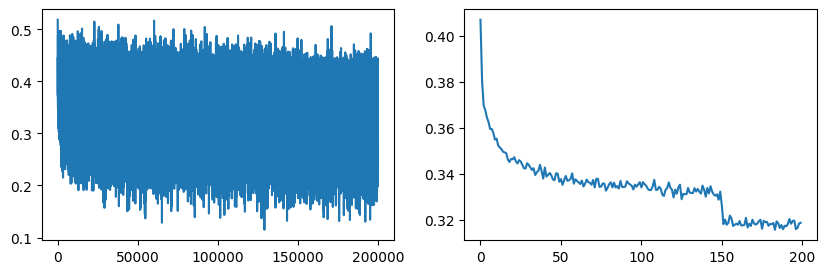

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(lossi)
ax2.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

## validate

In [187]:
for layer in model.layers:
  layer.training = False

@torch.no_grad()
def split_loss(s):
  """s is one of 'train', 'val', 'test'
  """
  xs, ys = { 'train': (X_train, Y_train),
          'val': (X_val, Y_val,),
           'test': (X_test, Y_test)}[s]
  # forward pass
  logits = model(xs)
  loss = F.cross_entropy(logits, ys)
  print(s, loss.item())

split_loss('train')
split_loss('val')

train 2.0599002838134766
val 2.10386061668396


## Sample

In [188]:
with torch.no_grad():
  for _ in range(20):
    out=[]
    context=[0]*block_size

    while True:
      logits = model(torch.tensor([context]))

      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1)
      context = context[1:]+[ix]
      out.append(ix.item())
      if ix==0:
        break
    print(''.join(itos[i] for i in out))

damiara.
alyzan.
fard.
maden.
shayah.
ayvorie.
rossot.
emon.
catine.
aib.
alittt.
grachiri.
jemin.
ana.
alynna.
jamaurole.
farashton.
serikia.
cer.
tyra.
